In [11]:
import numpy as np

import keras
import keras.backend as K
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten, BatchNormalization, Activation
from keras.regularizers import l2
    
WEIGHT_DECAY = 5e-4 / 2
    
# siam-l2 from "Learning to Compare Image Patches via Convolutional Neural Networks"
descriptor = Sequential()

descriptor.add(Lambda(lambda x : (K.cast(x, 'int16') - 128) / 128, input_shape=IMAGE_PATCH_SHAPE))

descriptor.add(Conv2D(96, kernel_size=7, strides=3, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(192, kernel_size=5, strides=1, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(256, kernel_size=3, strides=1, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))

descriptor.add(Flatten())

descriptor.add(Lambda(lambda x : tf.nn.l2_normalize(x, axis=1))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [15]:
from keras.models import Model
from keras.layers import Input, Concatenate

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

decision = Concatenate()([descriptor_a, descriptor_b])
decision = Dense(512, activation='relu')(decision)
decision = Dense(1)(decision)
model = Model(inputs=[input_a, input_b], outputs=decision)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


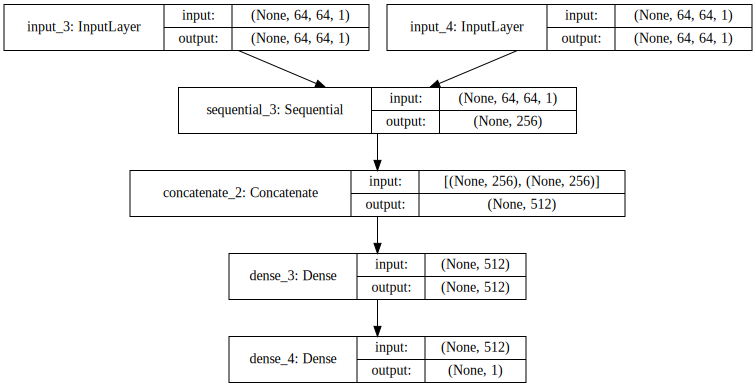

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
DATA_ROOT = '../data'
NOTREDAME = f'{DATA_ROOT}/notredame'
LIBERTY = f'{DATA_ROOT}/liberty'

!ls {NOTREDAME}/m50_*.txt

../data/notredame/m50_100000_100000_0.txt
../data/notredame/m50_10000_10000_0.txt
../data/notredame/m50_1000_1000_0.txt
../data/notredame/m50_200000_200000_0.txt
../data/notredame/m50_20000_20000_0.txt
../data/notredame/m50_2000_2000_0.txt
../data/notredame/m50_500000_500000_0.txt
../data/notredame/m50_50000_50000_0.txt
../data/notredame/m50_5000_5000_0.txt


In [18]:
from keras.optimizers import SGD, Adam
from keras.losses import hinge

model.compile(loss=hinge, optimizer=Adam())

In [19]:
!rm -r siam-dl-logs

rm: cannot remove 'siam-dl-logs': No such file or directory


In [20]:
%autoreload
from utils import create_generator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from batchtensorboard import BatchTensorBoard

NUM_TRAIN_PAIRS = 5000
NUM_VAL_PAIRS = 1000
BATCH_SIZE = 128
NUM_TRAIN_STEPS = NUM_TRAIN_PAIRS // BATCH_SIZE
NUM_VAL_STEPS = NUM_VAL_PAIRS // BATCH_SIZE

train_generator = create_generator(NOTREDAME, NUM_TRAIN_PAIRS, BATCH_SIZE)
validation_generator = create_generator(LIBERTY, NUM_VAL_PAIRS, BATCH_SIZE)

tensorboard = BatchTensorBoard(log_dir='siam-dl-logs')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001)
checkpointer = ModelCheckpoint('siam-dl-weights.hdf5')

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_STEPS, epochs=100, 
    validation_data=validation_generator, validation_steps=NUM_VAL_STEPS, 
    callbacks=[tensorboard, checkpointer])

Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,64,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: sequential_3/lambda_3/truediv/Cast = Cast[DstT=DT_FLOAT, SrcT=DT_INT16, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_3/lambda_3/sub/_353)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: sequential_3_1/batch_normalization_6/Shape/_503 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_816_sequential_3_1/batch_normalization_6/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'sequential_3/lambda_3/truediv/Cast', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-2a9ad6e58f88>", line 7, in <module>
    descriptor_a = descriptor(input_a)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/models.py", line 549, in call
    return self.model.call(inputs, mask)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 2236, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/core.py", line 663, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-14-ab734b0f9d93>", line 10, in <lambda>
    descriptor.add(Lambda(lambda x : (K.cast(x, 'int16') - 128) / 128, input_shape=IMAGE_PATCH_SHAPE))
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 979, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1073, in _truediv_python3
    x = cast(x, dtype)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 787, in cast
    x = gen_math_ops.cast(x, base_type, name=name)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1525, in cast
    "Cast", x=x, DstT=DstT, name=name)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/semyon/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,64,64,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: sequential_3/lambda_3/truediv/Cast = Cast[DstT=DT_FLOAT, SrcT=DT_INT16, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_3/lambda_3/sub/_353)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: sequential_3_1/batch_normalization_6/Shape/_503 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_816_sequential_3_1/batch_normalization_6/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

